In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z = 1 + 1j
z1 = 1 + 0j
print(np.angle(z,z1))
print(np.cos(np.angle(z,z1)*np.pi/180))
print(z.conjugate())
y = z*np.exp(complex(0,np.pi/2))
print(y)

45.0
0.7071067811865476
(1-1j)
(-0.9999999999999999+1j)


In [3]:
def cons_panel_vel(z,panel,gamma):
    z1 = panel[0]
    z2 = panel[1]
    theta = np.angle(z2 - z1)*np.pi/180  # angle in radians
    lambda_ = np.abs(z1 - z2)
    z_prime = ( z - z1 )*np.exp(complex(0,-1*theta))
    vel = (complex(0,-1)/(2*np.pi))*(gamma)*np.log((z_prime - lambda_)/z_prime)*np.exp(complex(0,theta))
    
    return vel.conjugate()

In [4]:
# vel blows up at z1 , z2 

def linear_panel_vel(z,z1,z2,gamma1,gamma2):
    theta = np.angle(z2 - z1)*np.pi/180  # angle in radians
    lambda_ = np.abs(z1-z2)
    z_prime = (z - z1)*np.exp(complex(0,-1*theta))
    vel = (complex(0,-1)/(2*np.pi))*(gamma1*((z_prime/lambda_ - 1)*np.log((z_prime - lambda_)/z_prime) + 1) \
                                     -1*gamma2*((z_prime/lambda_)*np.log((z_prime - lambda_)/z_prime ) + 1))*np.exp(complex(0,theta))

    return vel.conjugate()

In [5]:
def cons_panel_net_velocity(point, panels, gammas):
    net_vel = 0.0 + 0.0j
    for i,panel in enumerate(panels):
        net_vel  = net_vel + cons_panel_vel(point,panel,gammas[i])

    return net_vel


# discritize using cons panels
```python
centre = 0 + 0j
R = 1
num_panels = 30
panels = np.zeros((num_panels,2),dtype=np.complex128)
gammas = np.zeros(num_panels)
z1  = centre + complex(R,0)

for i,panel in enumerate(panels):
    theta = 2*np.pi/num_panels
    panel[0] = z1
    panel[1] = z1*np.exp(complex(0,theta))
    z1 = panel[1]
```

In [6]:
def get_panels(R,centre,num_panels):
    panels = np.zeros((num_panels,2),dtype=np.complex128)
    z1  = centre + complex(R,0)
    for i,panel in enumerate(panels):
        theta = 2*np.pi/num_panels
        panel[0] = z1
        panel[1] = z1*np.exp(complex(0,theta))
        z1 = panel[1]
    return panels

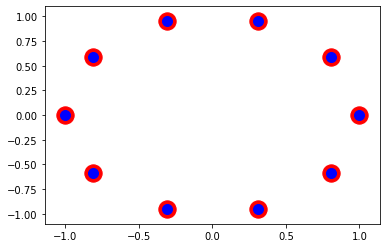

In [7]:
panels = get_panels(1,0.0+0.0j,10)
plt.scatter(panels[:,0].real,panels[:,0].imag,color='r',s=300)
plt.scatter(panels[:,1].real,panels[:,1].imag,color='b',s=100)

[[ 1.        +0.00000000e+00j  0.30901699+9.51056516e-01j]
 [ 0.30901699+9.51056516e-01j -0.80901699+5.87785252e-01j]
 [-0.80901699+5.87785252e-01j -0.80901699-5.87785252e-01j]
 [-0.80901699-5.87785252e-01j  0.30901699-9.51056516e-01j]
 [ 0.30901699-9.51056516e-01j  1.        -2.22044605e-16j]]


(-1.0994713695023444,
 1.0999748271191592,
 -1.0998615404412626,
 1.0998615404412626)

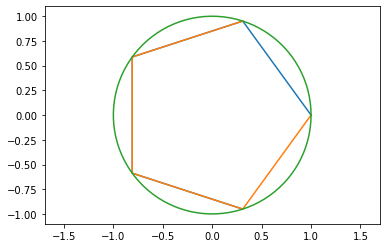

In [8]:
test_panels = get_panels(1,0 + 0j , 5)
test_theta = np.linspace(0,2*np.pi,100)
x = 1*np.cos(test_theta)
y = 1*np.sin(test_theta)
print(test_panels)
plt.plot(test_panels.real,test_panels.imag)
plt.plot(x,y)
plt.axis('equal')

In [9]:
gammas = np.ones(len(panels))
point = 5 + 5j
net_vel = cons_panel_net_velocity(point,panels,gammas)
print(net_vel)
A = np.ones((100,10))
print(np.concatenate((A ,np.ones((1,10) )), axis = 0).shape)

(0.10341152970345606-0.09985424366312737j)
(101, 10)


In [10]:
# @numba.njit
def krasny_velocity(z1,z0,gamma,delta):
    """
    parameters:
    
    z0 : position of the vortex
    z1 : complex point where velocity is to be calculated
    gamma : strength of the vortex placed at z0
    
    Returns:
    vel : velocity at point z1 due to the vortex placed at z0
    """
    
    dz = z1 - z0
    x = dz.real
    y = dz.imag
    
    phi = (gamma/(2*np.pi*(x*x + y*y + delta*delta)))*(-1j)*dz.conjugate()
    
    u = phi.real
    v = (-1)*phi.imag
    
    return u , v

In [11]:
# @numba.njit
def krasny_net_velocity(vortex, vortexs, gammas, deltas):
    u = 0
    v = 0
    curr_idx = np.argmin(np.abs(vortexs - vortex))
    for i,z0 in enumerate(vortexs):
        if curr_idx != i :
            u_temp , v_temp  = krasny_velocity(vortex,z0,gammas[i],deltas[i])
            u = u + u_temp
            v = v + v_temp
    return complex(u , v)

In [12]:
# dot product of two complex numbers
def dot(x,y):
    return x.real*y.real + x.imag*y.imag

In [13]:
def get_element(control,panel,gamma):
    velocity = cons_panel_vel(control,panel,gamma)
    normal = ( (panel[1] - control)*np.exp(complex(0,np.pi)) ) / np.abs(panel[1] - control)
    return dot(velocity,normal)
    

```python
gammas = np.ones(len(panels))
num_panels = len(gammas)
control_pts = np.array([(panel[0] + panel[1])/2 for panel in panels ])
# vel_control_points = cons_panel_net_velocity(control_pts,panels,gammas)
A = np.zeros((num_panels,num_panels))
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if i != j :
            A[i,j] = get_element(control_pts[i],panels[j],gammas[j])  #cons_panel_vel(control_pts[j],panels[i],gammas[i])

A = np.concatenate( (A,np.ones((1,num_panels))) , axis = 0 )
b = np.zeros((num_panels + 1 , 1))
gammas = np.linalg.lstsq(A, b,rcond=None)
print(gammas[-1])
```

In [14]:
def get_element_b(control,free_stream_vel):
    theta = np.angle( control - 0 + 0j )*np.pi/180
    normal = control/np.abs(control)
    V_r = 0
    V_th = -2*free_stream_vel*np.sin(theta)
    vel = complex(V_r*np.cos(theta) + V_th*np.sin(theta) , V_r*np.sin(theta) - V_th*np.cos(theta) )
    return -1*dot(vel,normal)
    

In [84]:
def solve_gammas(panels,free_stream_vel):
    gammas = np.ones(len(panels))
    num_panels = len(gammas)
    control_pts = (panels[:,0] + panels[:,1])/2
    A = np.zeros((num_panels,num_panels))
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if i != j :
                A[i,j] = get_element(control_pts[j],panels[i],gammas[i])

    A = np.concatenate( (A,np.ones((1,num_panels))) , axis = 0 )
    b = np.zeros((num_panels + 1 , 1))
    for i in range(num_panels):
        b[i,0] = get_element_b(control_pts[i],free_stream_vel)
    return  np.array(np.linalg.lstsq(A, b,rcond=None)[-1])

In [85]:
len((panels[:,0] + panels[:,1])/2) , len(panels)

(200, 200)

In [86]:
solve_gammas(panels,1)

array([1.41459258e+01, 5.18042874e-01, 4.95991109e-01, 4.81346615e-01,
       4.71825688e-01, 4.68557416e-01, 4.61273606e-01, 4.54013579e-01,
       4.51175440e-01, 4.43115756e-01, 4.40889303e-01, 4.33126139e-01,
       4.30604040e-01, 4.23085942e-01, 4.20222963e-01, 4.12996288e-01,
       4.09815443e-01, 4.02919195e-01, 3.99445782e-01, 3.92902789e-01,
       3.89164655e-01, 3.82988350e-01, 3.79013731e-01, 3.73210065e-01,
       3.69026573e-01, 3.63595540e-01, 3.59229689e-01, 3.54166501e-01,
       3.49643502e-01, 3.44939517e-01, 3.40283227e-01, 3.35926703e-01,
       3.31159684e-01, 3.27136386e-01, 3.22280020e-01, 3.18573697e-01,
       3.13648344e-01, 3.10241098e-01, 3.05266288e-01, 3.02138845e-01,
       2.97133491e-01, 2.94265379e-01, 2.89248002e-01, 2.86617672e-01,
       2.81606622e-01, 2.79191522e-01, 2.74205178e-01, 2.71981813e-01,
       2.67038731e-01, 2.64982756e-01, 2.60101719e-01, 2.58188120e-01,
       2.53388039e-01, 2.51591452e-01, 2.46891089e-01, 2.45186293e-01,
      

In [87]:
def true_solution(centre,R,stream_vel,r,num_points):
    vel = np.zeros(num_points,dtype=np.complex128)
    pos = np.zeros(num_points,dtype=np.complex128)
    for i in range(num_points):
        theta = i*(np.pi*2/num_points)
        pos[i] = centre + complex(r*np.cos(theta),r*np.sin(theta))
        V_r = stream_vel*( 1 - np.square(R/r) )*np.cos(theta)
        V_th = stream_vel*( 1 + np.square(R/r) )*np.sin(theta) # -1* (V_th ) gives error ???
        vel[i] = complex(V_r*np.cos(theta) + V_th*np.sin(theta) , V_r*np.sin(theta) - V_th*np.cos(theta) )
    return (vel , pos)

(1+0j)  here vel is  0 k k l 0
(6.123233995736766e-17+1j)  here vel is  2 k k l 0
(-1+1.2246467991473532e-16j)  here vel is  0 k k l 0
(-1.8369701987210297e-16-1j)  here vel is  2 k k l 0
(4,)


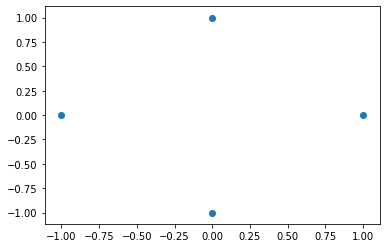

In [88]:
(test_vel , test_pos) = true_solution(0 + 0j , 1 , 1 , 1 , 4)
for test_pos1 , test_vel1 in zip(test_pos,test_vel):
    print(test_pos1, " here vel is " , int(test_vel1.real),"k k l",int(test_vel1.imag))

print(test_pos.shape)
plt.scatter(test_pos.real,test_pos.imag)

# Putting it all together 

In [89]:
def plot_error(num_panels,free_stream_vel,R,centre,r_all,num_pos):
    panels = get_panels(R,centre,num_panels)
#     print(panels)
    gammas = solve_gammas(panels,free_stream_vel)

    error = []

    for r in r_all :
        (true_vel , pos) = true_solution(centre,R,free_stream_vel,r,num_pos)
        cal_vel = cons_panel_net_velocity(pos, panels, gammas)
        error.append(np.abs(np.sum((true_vel - cal_vel))/num_pos))

    plt.plot(r_all,np.array(error))
    plt.title("final error  = " + str(error[-1]))
    plt.show()

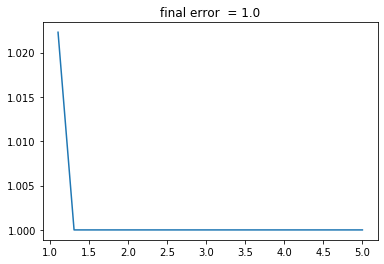

In [90]:
# testing 

# setup
num_panels = 30
free_stream_vel = 1
R = 1
centre = 0.0 + 0.0j
r_all = np.linspace(1.1,5,20)
num_pos = 200



plot_error(num_panels,free_stream_vel,R,centre,r_all,num_pos)

20


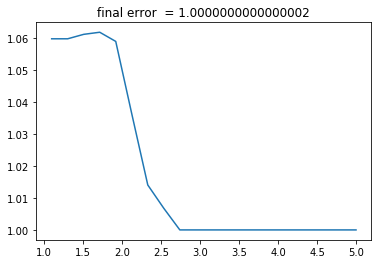

200


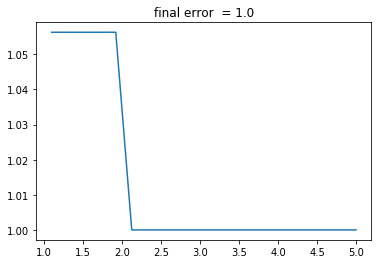

In [91]:
# setup
# num_panels = 20
free_stream_vel = 1
R = 2
centre = 0.0 + 0.0j
r_all = np.linspace(1.1,5,20)
num_pos = 200



num_p = np.linspace(20,200,2)

for num_panels in num_p:
    num_panels = int(num_panels)
    print(num_panels)
    plot_error(num_panels,free_stream_vel,R,centre,r_all,num_pos)

In [92]:
def error_vs_panels():
    pass
    

[1.0]
[1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0000000000000002]


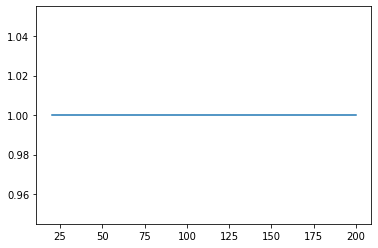

In [93]:
# setup
# num_panels = 20
free_stream_vel = 1
R = 1
centre = 0.0 + 0.0j
r = 5
num_pos = 200

num_p = np.linspace(20,200,5)

error = []



for num_panels in num_p:
    num_panels = int(num_panels)
    panels = get_panels(R,centre,num_panels)
    gammas = solve_gammas(panels,free_stream_vel)

    (true_vel , pos) = true_solution(centre,R,free_stream_vel,r,num_pos)
    cal_vel = cons_panel_net_velocity(pos, panels, gammas)
    error.append(np.abs(np.sum((true_vel - cal_vel))/num_pos))
    print(error)

plt.plot(num_p,error)

    